# Multi-bin Poisson

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import logging
import json

import pyhf
from pyhf import Model, optimizer
from pyhf.simplemodels import hepdata_like

from scipy.interpolate import griddata
import scrapbook as sb

In [3]:
def plot_results(testmus, cls_obs, cls_exp, poi_tests, test_size = 0.05):
    plt.plot(poi_tests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(poi_tests, cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def invert_interval(testmus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size,
                                             list(reversed(yvals)),
                                             list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,
                                    list(reversed(yvals)),
                                    list(reversed(testmus)))
    return point05cross

def plot_histo(ax, binning, data):
    bin_width = (binning[2]-binning[1])/binning[0]
    bin_leftedges = np.linspace(binning[1],binning[2],binning[0]+1)[:-1]
    bin_centers = [le + bin_width/2. for le in bin_leftedges]
    ax.bar(bin_centers,data,1, alpha=0.5)


def plot_data(ax, binning, data):
    errors = [math.sqrt(d) for d in data]
    bin_width = (binning[2]-binning[1])/binning[0]
    bin_leftedges = np.linspace(binning[1],binning[2],binning[0]+1)[:-1]
    bin_centers = [le + bin_width/2. for le in bin_leftedges]    
    ax.bar(bin_centers,data,0, yerr=errors, linewidth=0, error_kw = dict(ecolor='k', elinewidth = 1))
    ax.scatter(bin_centers, data, c = 'k')

In [4]:
validation_datadir = '../../validation/data'

{'exp': [1.0810606780537388,
  1.4517179965651292,
  2.0200754881420266,
  2.834863384648174,
  3.8487567494315487],
 'obs': 2.3800254370628036}

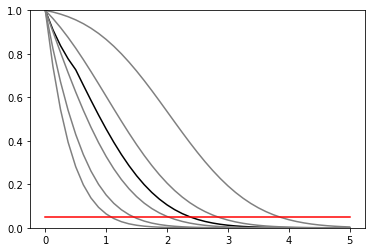

In [5]:
source = json.load(open(validation_datadir + '/1bin_example1.json'))
pdf = hepdata_like(source['bindata']['sig'], source['bindata']['bkg'], source['bindata']['bkgerr'])
data = source['bindata']['data'] + pdf.config.auxdata

init_pars  = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

poi_tests = np.linspace(0, 5, 41)
tests = [pyhf.utils.hypotest(poi_test, data, pdf, init_pars, par_bounds, return_expected_set=True) 
         for poi_test in poi_tests]
cls_obs = np.array([test[0] for test in tests]).flatten()
cls_exp = [np.array([test[1][i] for test in tests]).flatten() for i in range(5)]

plot_results(poi_tests, cls_obs, cls_exp, poi_tests)
invert_interval(poi_tests, cls_obs, cls_exp)

In [6]:
source = {
  "binning": [2,-0.5,1.5],
  "bindata": {
    "data":    [120.0, 145.0],
    "bkg":     [100.0, 150.0],
    "bkgerr":  [15.0, 20.0],
    "sig":     [30.0, 45.0]
  }
}


my_observed_counts = source['bindata']['data']

pdf = hepdata_like(source['bindata']['sig'], source['bindata']['bkg'], source['bindata']['bkgerr'])
data = my_observed_counts + pdf.config.auxdata


binning = source['binning']

nompars = pdf.config.suggested_init()


bonlypars = [x for x in nompars]
bonlypars[pdf.config.poi_index] = 0.0
nom_bonly = pdf.expected_data(bonlypars, include_auxdata = False)

nom_sb = pdf.expected_data(nompars, include_auxdata = False)

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

print(init_pars)

bestfit_pars = optimizer.unconstrained_bestfit(pyhf.utils.loglambdav, data, pdf, init_pars, par_bounds)
bestfit_cts  = pdf.expected_data(bestfit_pars, include_auxdata = False)

[1.0, 1.0, 1.0]


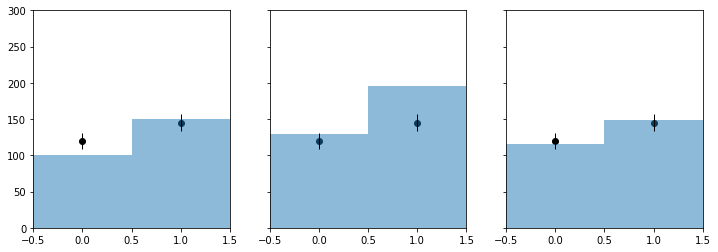

In [7]:
f, axarr = plt.subplots(1,3,sharey=True)
f.set_size_inches(12,4)

plot_histo(axarr[0], binning, nom_bonly)
plot_data(axarr[0], binning, my_observed_counts)
axarr[0].set_xlim(binning[1:])

plot_histo(axarr[1], binning, nom_sb)
plot_data(axarr[1], binning, my_observed_counts)
axarr[1].set_xlim(binning[1:])

plot_histo(axarr[2], binning, bestfit_cts)
plot_data(axarr[2], binning, my_observed_counts)
axarr[2].set_xlim(binning[1:])

plt.ylim(0,300);

In [8]:
##
##  DUMMY 2D thing
##

def signal(m1, m2):
    massscale = 150.
    minmass = 100.
    countscale = 2000
    
    effective_mass = np.sqrt(m1**2 + m2**2)
    return [countscale*np.exp(-(effective_mass-minmass)/massscale), 0]

def CLs(m1,m2):
    signal_counts = signal(m1, m2)
    pdf = hepdata_like(signal_counts, source['bindata']['bkg'], source['bindata']['bkgerr'])
    try:
        cls_obs, cls_exp_set = pyhf.utils.hypotest(1.0, data, pdf, init_pars, par_bounds, return_expected_set=True)
        return cls_obs, cls_exp_set, True
    except AssertionError:
        print('fit failed for mass points ({}, {})'.format(m1, m2))
        return None, None, False

In [9]:
nx, ny = 15, 15
grid = grid_x, grid_y = np.mgrid[100:1000:complex(0, nx), 100:1000:complex(0, ny)]
X = grid.T.reshape(nx * ny, 2)
results = [CLs(m1, m2) for m1, m2 in X]

In [10]:
X = np.array([x for x,(_,_,success) in zip(X,results) if success])
yobs = np.array([obs for obs, exp, success in results if success]).flatten()
yexp = [np.array([exp[i] for obs, exp, success in results if success]).flatten() for i in range(5)]

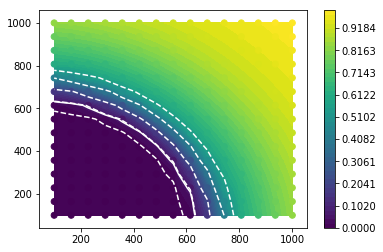

In [11]:
int_obs = griddata(X, yobs, (grid_x, grid_y), method='linear')

int_exp = [griddata(X, yexp[i], (grid_x, grid_y), method='linear') for i in range(5)]

plt.contourf(grid_x, grid_y, int_obs, levels = np.linspace(0,1))
plt.colorbar()

plt.contour(grid_x, grid_y, int_obs, levels = [0.05], colors = 'w')
for level in int_exp:
    plt.contour(grid_x, grid_y, level, levels = [0.05], colors = 'w', linestyles = 'dashed')

plt.scatter(X[:,0], X[:,1], c = yobs, vmin = 0, vmax = 1);

In [12]:
sb.glue("number_2d_successpoints", len(X))